# Желтое такси: оформление проекта

Задание выполнил: *Владимир Старостенков*  
e-mail: *vladimir.starostenkov@gmail.com*  
machinelearning2016.slack.com: *vladimir.starostenkov*

В работе использовал folium и ipywidgets:

https://github.com/python-visualization/folium  
pip install git+https://github.com/python-visualization/folium.git

https://github.com/ipython/ipywidgets  
pip install ipywidgets  
jupyter nbextension enable --py --sys-prefix widgetsnbextension  


In [13]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from IPython.display import HTML
import folium

In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [15]:
data = pd.read_csv("week7_data.csv", parse_dates=['tpep_pickup_datetime'], index_col=[0])

In [16]:
regions = data.region.unique()

In [17]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Арифметический рассчет координат полигона региона - быстро работает
def region2poligon(region):
    lon_max = -73.70001
    lon_min = -74.25559
    lat_max = 40.91553
    lat_min = 40.49612
    lat = (lat_max - lat_min)/50
    lon = (lon_max - lon_min)/50
    
    #  b---c
    #  |   |
    #  a---d

    a_lat = lat_min + (int(region)%50-1)*lat
    a_lon = lon_min + (int(region)/50)*lon
       
    b_lat = lat_min + (int(region)%50)*lat
    b_lon = a_lon
        
    c_lat = b_lat
    c_lon = lon_min + (int(region)/50+1)*lon
        
    d_lat = a_lat
    d_lon = c_lon
        
    polygon = [[[a_lon, a_lat], [b_lon, b_lat], [c_lon, c_lat], [d_lon, d_lat]]]
    return polygon

In [6]:
def calc_average_trip_count(df, start_dt, end_dt):
    return df[start_dt:end_dt].groupby(['region'])['y'].mean().to_dict()

In [7]:
# построение словаря, который похож на GeoJSON, который требуется folium
# словарь состоит из списка "features", в каждой есть id, который соответствует нашей ячейке (региону)
# и координаты полигоны, соответствует этой ячейке
def createFeatureCollection(regions):
    d = {"type": "FeatureCollection", "features": []}
    for r in regions:
        d["features"].append({"id": r,
                              "type": "Feature",
                              "geometry": {
                                            "type": "Polygon",
                                            "coordinates": region2poligon(r)
                                          }
                              })
    return d

In [8]:
lon_max = -73.70001
lon_min = -74.25559
lat_max = 40.91553
lat_min = 40.49612

dts = data.index.unique()
dates = list(data.index.unique())

def show_map(date):
    
    date = np.datetime64(date)
    
    my_data = data.loc[date].reset_index()
    average_trip_count = calc_average_trip_count(data, date, date)
    
    threshold_scale = [0] + [lst[-1] for lst in np.array_split(np.sort(data.y.unique()), 5)]
    
    final_map = folium.Map(location=[(lat_max+lat_min)/2, (lon_max+lon_min)/2], tiles='Stamen Toner', zoom_start=11)
    
    final_map.choropleth(
        geo_str=createFeatureCollection(regions),
        data=my_data,
        columns=['region','y'],
        key_on='feature.id',
        threshold_scale=threshold_scale,
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Trip Count',
        highlight=True
    )

    return final_map

In [9]:
widgets.interact(show_map, date=widgets.Dropdown(options=dates,description='Select Date and Time:'))

<IPython.core.display.Javascript object>


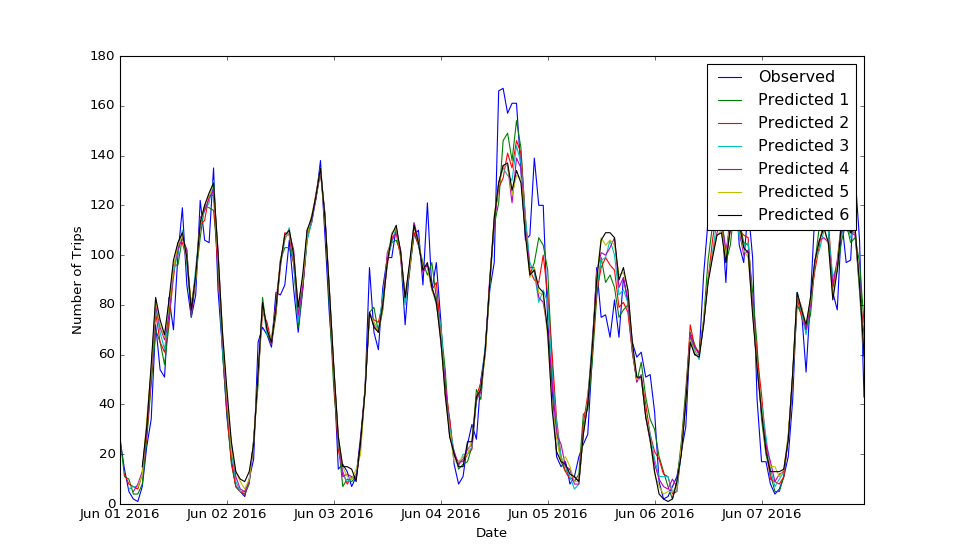

In [10]:
slider_start = widgets.SelectionSlider(description='Start date',
                                       options=dates,
                                       continuous_update=False,
                                       layout=widgets.Layout(width='80%'))
slider_end = widgets.SelectionSlider(description='End date',
                                     options=dates,
                                     continuous_update=False,
                                     layout=widgets.Layout(width='80%'))
slider_end.value = dates[167]

def slider_start_changed(value):
    slider_end.value = max(slider_start.value, slider_end.value)

def slider_end_changed(value):
    slider_start.value = min(slider_start.value, slider_end.value)

slider_start.observe(slider_start_changed, 'value')
slider_end.observe(slider_end_changed, 'value')

region_selector = widgets.Dropdown(description='Region', options=list(regions))

def on_button_clicked(value):    
    region = region_selector.value
    start_dt = slider_start.value
    end_dt = slider_end.value
    
    my_data = data[start_dt:end_dt]
    my_data = my_data[my_data.region == region]
    ax.clear()
    plt.xlabel('Date')
    plt.ylabel('Number of Trips')
    if cb_y.value == True:
        ax.plot(my_data.y, label="Observed")
        
    for i in range(0, 6):
        if cbs[i].value == True:
            ax.plot(my_data['p' + str(i+1)], label="Predicted " + str(i+1))
        
    plt.legend()
    plt.draw()
    
button = widgets.Button(description="Update the graph")
button.on_click(on_button_clicked)

cb_y = widgets.Checkbox(description = "Observed", value=True)
cbs = []
for i in range(1, 7):
    cbs.append(widgets.Checkbox(description = "Pred. " + str(i), value=True))
cb_container = widgets.HBox(children=[cb_y] + cbs, layout=widgets.Layout(width='80%'))

graph_widgets = widgets.Box(children=[slider_start, slider_end, region_selector, cb_container, button])

display(graph_widgets)

fig, ax = plt.subplots(figsize=(12,7))
on_button_clicked("initial")

Спасибо за внимание!